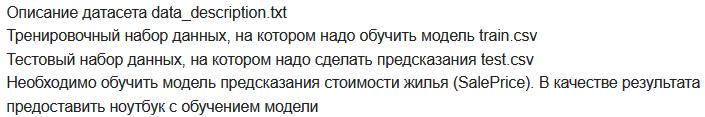



In [ ]:
import numpy as np
import pandas as pd
import math
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных

In [ ]:
ls

catboost_info/  data_description.txt  sample_submission.csv  submission.csv  test.csv  train.csv


In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

# Анализ данных

In [ ]:
train.describe()

,GarageYrBlt,FullBath,1stFlrSF,BsmtFinSF1,TotRmsAbvGrd,OpenPorchSF,OverallQual,GarageCars,KitchenAbvGr,GrLivArea,2ndFlrSF,TotalBsmtSF,Fireplaces,SalePrice
count,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,1978.506164,1.565068,1162.626712,443.639726,6.517808,46.660274,6.099315,1.767123,1.046575,1515.463699,346.992466,1057.429452,0.613014,180921.195890
std,24.689725,0.550916,386.587738,456.098091,1.625393,66.256028,1.382997,0.747315,0.220338,525.480383,436.528436,438.705324,0.644666,79442.502883
min,1900.000000,0.000000,334.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,34900.000000
25%,1961.000000,1.000000,882.000000,0.000000,5.000000,0.000000,5.000000,1.000000,1.000000,1129.500000,0.000000,795.750000,0.000000,129975.000000
50%,1980.000000,2.000000,1087.000000,383.500000,6.000000,25.000000,6.000000,2.000000,1.000000,1464.000000,0.000000,991.500000,1.000000,163000.000000
75%,2002.000000,2.000000,1391.250000,712.250000,7.000000,68.000000,7.000000,2.000000,1.000000,1776.750000,728.000000,1298.250000,1.000000,214000.000000
max,2010.000000,3.000000,4692.000000,5644.000000,14.000000,547.000000,10.000000,4.000000,3.000000,5642.000000,2065.000000,6110.000000,3.000000,755000.000000


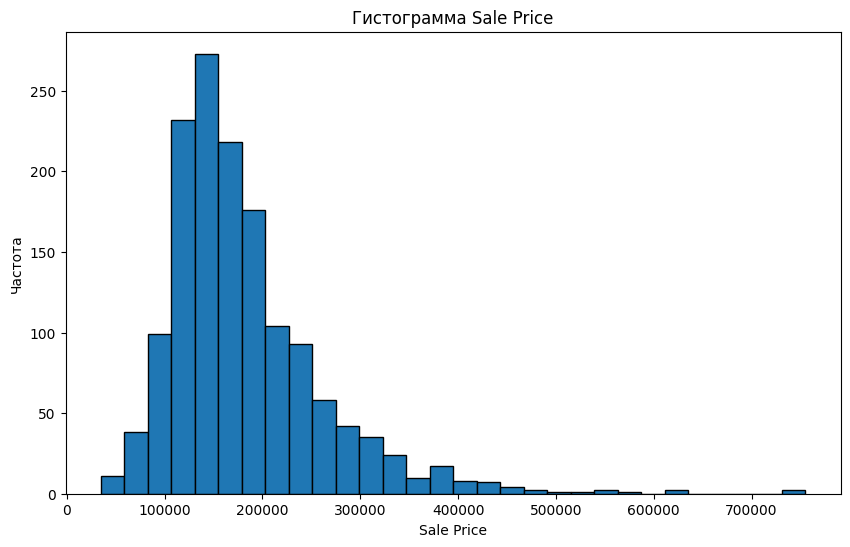

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(train['SalePrice'], bins=30, edgecolor='black')
plt.xlabel('Sale Price')
plt.ylabel('Частота')
plt.title('Гистограмма Sale Price')
plt.show()

Значения 'SalePrice' имеют нормальное распределение, смещенное вправо. Это можно исправить можно применить логарифмическое преобразование.

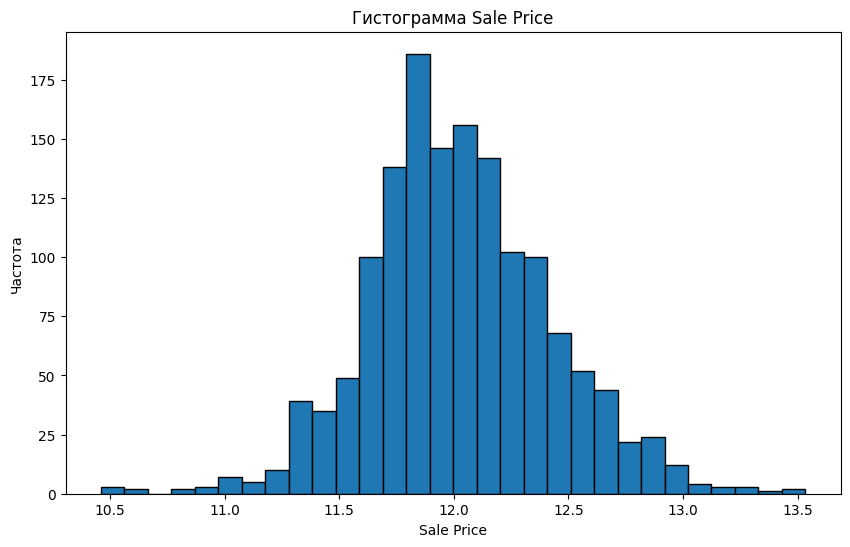

In [ ]:
train['SalePrice'] = np.log(train['SalePrice'])

plt.figure(figsize=(10, 6))
plt.hist(train['SalePrice'], bins=30, edgecolor='black')
plt.xlabel('Sale Price')
plt.ylabel('Частота')
plt.title('Гистограмма Sale Price')
plt.show()

## Корреляция числовых признаков

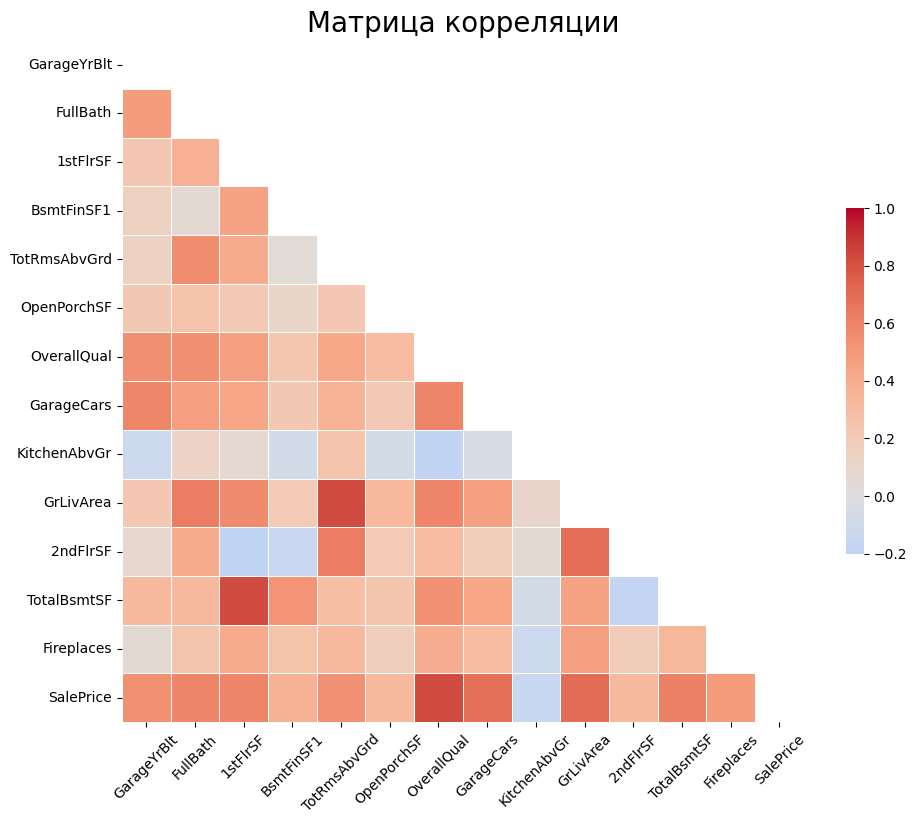

In [ ]:
train_non_categorical = train.drop(columns=train.select_dtypes(include=['object']).columns)
corr = train_non_categorical.corr()

# Маска для скрытия верхнего треугольника матрицы корреляции
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
heatmap = sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, center=0,
                      square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.xticks(rotation=45)
plt.title('Матрица корреляции', fontsize=20)
plt.show()



Из матрицы корреляции видно, что существует сильная положительная корреляция между следующими парами параметров:

* Площадь первого этажа (1stFlrSF) и общая площадь подвала (TotalBsmtSF);
* Общая жилая площадь (GrLivArea) и общее количество комнат выше уровня земли (TotRmsAbvGrd).

Найдем корреляционные пары.


In [ ]:
corr = train_non_categorical.corr().stack().reset_index()
corr.columns = ['Feature 1', 'Feature 2', 'Correlation Coefficient']

# Сортировка каждой пары переменных
corr[['Feature 1', 'Feature 2']] = np.sort(corr[['Feature 1', 'Feature 2']], axis=1)
# Удаление дублирующихся пар и самокорреляции
sorted_corr = corr[corr['Feature 1'] != corr['Feature 2']].drop_duplicates().sort_values(by='Correlation Coefficient', ascending=False)

print("Пары признаков с положительной кросс-корреляцией:\n")
print(sorted_corr.head(10))

Пары признаков с положительной кросс-корреляцией:

       Feature 1     Feature 2  Correlation Coefficient
65     GrLivArea  TotRmsAbvGrd                 0.825489
39      1stFlrSF   TotalBsmtSF                 0.819530
97   OverallQual     SalePrice                 0.817184
139    GrLivArea     SalePrice                 0.700927
136     2ndFlrSF     GrLivArea                 0.687501
111   GarageCars     SalePrice                 0.680625
23      FullBath     GrLivArea                 0.630012
66      2ndFlrSF  TotRmsAbvGrd                 0.616423
167    SalePrice   TotalBsmtSF                 0.612134
91    GarageCars   OverallQual                 0.600671


Найдем наиболее коррелирующие с 'SalePrice' параметры.

In [ ]:
correlation = train_non_categorical.corr()

# Отсортированные по убыванию корреляции параметры
top_corr_features = correlation['SalePrice'].sort_values(ascending=False).head(15)

print("10 параметров с наибольшей степенью корреляции с 'SalePrice':\n")
print(top_corr_features)

10 параметров с наибольшей степенью корреляции с 'SalePrice':

SalePrice       1.000000
OverallQual     0.817184
GrLivArea       0.700927
GarageCars      0.680625
TotalBsmtSF     0.612134
1stFlrSF        0.596981
FullBath        0.594771
GarageYrBlt     0.541073
TotRmsAbvGrd    0.534422
Fireplaces      0.489449
BsmtFinSF1      0.372023
OpenPorchSF     0.321053
2ndFlrSF        0.319300
KitchenAbvGr   -0.147548
Name: SalePrice, dtype: float64


Параметры 'TotalBsmtSF' и 'TotRmsAbvGrd' можно удалить, так как они имеют высокую степень корреляции с другими параметрами (1stFlrSF и GrLivArea соответственно).

## Корреляция категориальных признаков

<ipython-input-80-3865918706a4>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[row, col].set_xticklabels(labels[:len(ax[row, col].get_xticks())], fontsize=8)
<ipython-input-80-3865918706a4>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[row, col].set_xticklabels(labels[:len(ax[row, col].get_xticks())], fontsize=8)
<ipython-input-80-3865918706a4>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[row, col].set_xticklabels(labels[:len(ax[row, col].get_xticks())], fontsize=8)
<ipython-input-80-3865918706a4>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[row, col].set_xticklabels(labels[:len(ax[row, col].get_xticks())], fontsize=8)
<ipython-input-80-3865918706a4>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[row, col].set_xticklabels(labels[:len(ax[row, col].get_xticks())], fontsize=8)
<ipython-input-80-3865918

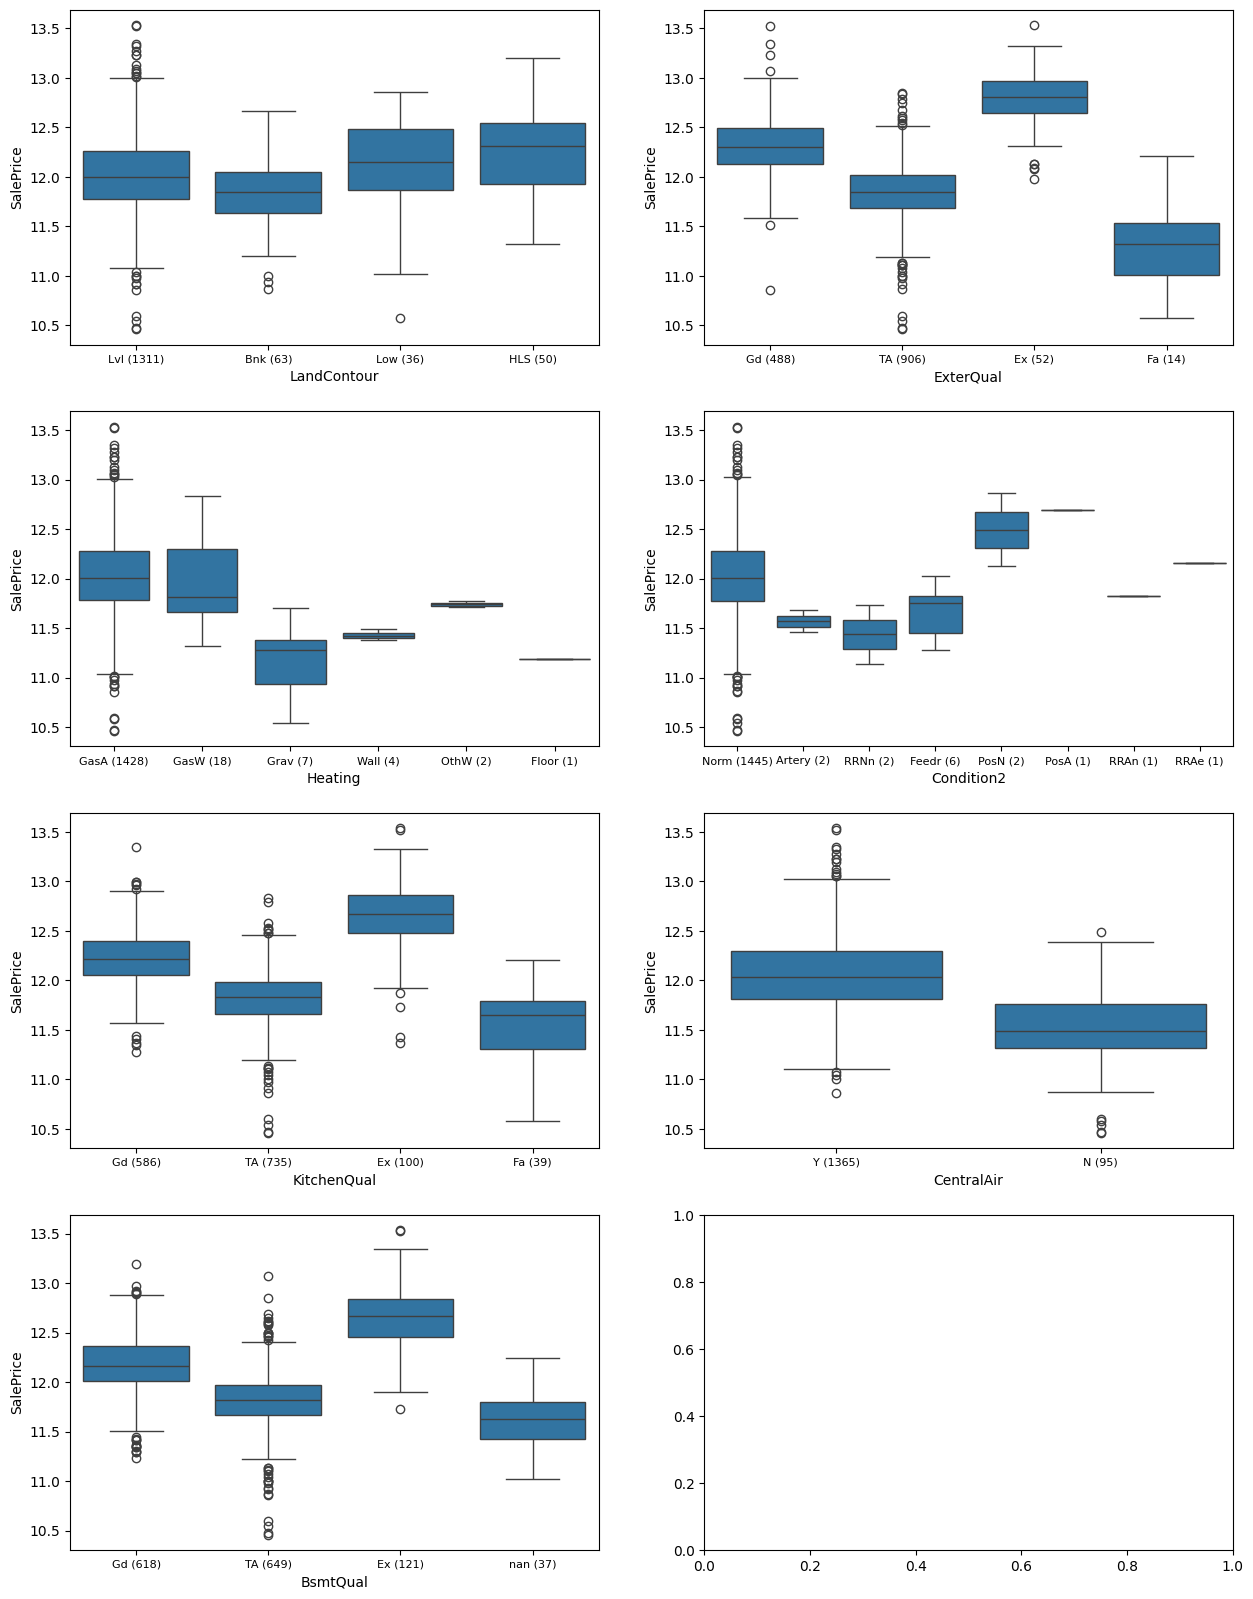

In [ ]:
categorical_cols = train.select_dtypes(include=['object']).columns

# Количество строк и столбцов для сетки графиков
n_rows = math.ceil((len(categorical_cols))/ 2)
n_cols = 2


fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, n_rows*5))

i = 0
for cat_col in categorical_cols:

    row = i // n_cols
    col = i % n_cols

    # Boxplot по оси x отложены значения категориального признака,
    # по оси y - значения SalePrice (цены продажи)
    sns.boxplot(x=train[cat_col], y=train['SalePrice'], ax=ax[row, col])

    # Подписи для оси x, содержащие информацию о количестве значений
    # каждого класса в категориальном столбце
    labels = ['{} ({})'.format(label, train[cat_col].tolist().count(label)) for label in train[cat_col].unique()]

    # Установка подписей для оси x в графике с координатами (row, col)
    ax[row, col].set_xticklabels(labels[:len(ax[row, col].get_xticks())], fontsize=8)
    i += 1



Некоторые столбцы содержат очень мало значений сразу в нескольких классах:

* Condition2 имеет 8 классов и 1438 значений относятся к классу 'Norm';
* Heating имеет 6 классов и 1421 значение относится к классу 'GasA'.


Удаляем выбранные ранее столбцы.

In [ ]:
train_test = [train, test]

for df in train_test:
    df.drop(['TotalBsmtSF','TotRmsAbvGrd'], axis=1, inplace = True)
    df.drop(['Condition2', 'Heating'], axis=1, inplace = True)

# Отсутствующие данные

In [ ]:
missing_data_dict = {}

for i, df in enumerate(train_test):

    # Общее количество отсутствующих значений в каждом столбце,
    # отсортированное в порядке убывания
    total = df.isnull().sum().sort_values(ascending=False)
    # Процент отсутствующих значений в каждом столбце,
    # отсортированный в порядке убывания
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)

    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_data = missing_data[missing_data['Total'] >= 1]
    missing_data_dict[f'df_{i+1}'] = missing_data

missing_data_train = missing_data_dict['df_1']
missing_data_test = missing_data_dict['df_2']

print("Отсутствующие данные в обучающем наборе данных:\n")
print(missing_data_train)
print("\nОтсутствующие данные в тестовом наборе данных:\n")
print(missing_data_test)

Отсутствующие данные в обучающем наборе данных:

             Total   Percent
GarageYrBlt     81  0.055479
BsmtQual        37  0.025342

Отсутствующие данные в тестовом наборе данных:

             Total   Percent
GarageYrBlt     78  0.053461
BsmtQual        44  0.030158
BsmtFinSF1       1  0.000685
GarageCars       1  0.000685
KitchenQual      1  0.000685


Предположим, что отсутствие года постройки гаража показывает отсутствие самого гаража и заполним отсутствующие данные самым ранним годом постройки гаража.

In [ ]:
for df in train_test:
    df['GarageYrBlt'].fillna(train['GarageYrBlt'].min(), inplace=True)

Предположим, что BsmtQual также означает отсутствие подвала и заполним пропущенные значения на 'None'.

In [ ]:
for df in train_test:
    df['BsmtQual'].fillna('None', inplace=True)

Остальные отсутствующие значения представлены в одном экземпляре. Заполним эти значения самыми популярными значениями (в случае с категориальными значениями) и медианными значениями (в случае с числовыми значениями).

In [ ]:
for df in train_test:
    df['BsmtFinSF1'].fillna(df['BsmtFinSF1'].median(), inplace=True)
    df['GarageCars'].fillna(df['GarageCars'].median(), inplace=True)
    df['KitchenQual'].fillna(df['KitchenQual'].mode()[0], inplace=True)

# Подготовка датасета и обучение модели

In [ ]:
# Преобразование категориальных переменных в фиктивные переменные
train = pd.get_dummies(train)
test = pd.get_dummies(test)

X_train = train.drop(columns=['SalePrice'])
y_train = train['SalePrice']

X_test = test
X_train, X_test = X_train.align(X_test, join='inner', axis=1)

In [ ]:
# Определение категориальных признаков
categorical_features_indices = np.where(train.dtypes == 'object')[0]

model = CatBoostRegressor(loss_function='RMSE', verbose = 0)
model.fit(X_train, y_train, cat_features=categorical_features_indices, verbose = False)

scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
rmse_scores = -scores
print("Средний RMSE: ", rmse_scores.mean())

Средний RMSE:  0.14605660976619142


# Предсказания

In [ ]:
predictions = model.predict(X_test)
predictions = np.exp(predictions)
predictions = pd.Series(predictions)

predictions_df = pd.DataFrame({
    'Id': submission['Id'],
    'SalePrice': predictions
})

predictions_df

,Id,SalePrice
0,1461,122619.005669
1,1462,156687.122743
2,1463,183730.181744
3,1464,173335.363023
4,1465,189766.544208
...,...,...
1454,2915,65856.500390
1455,2916,83996.100834
1456,2917,152504.928216
1457,2918,108050.267765


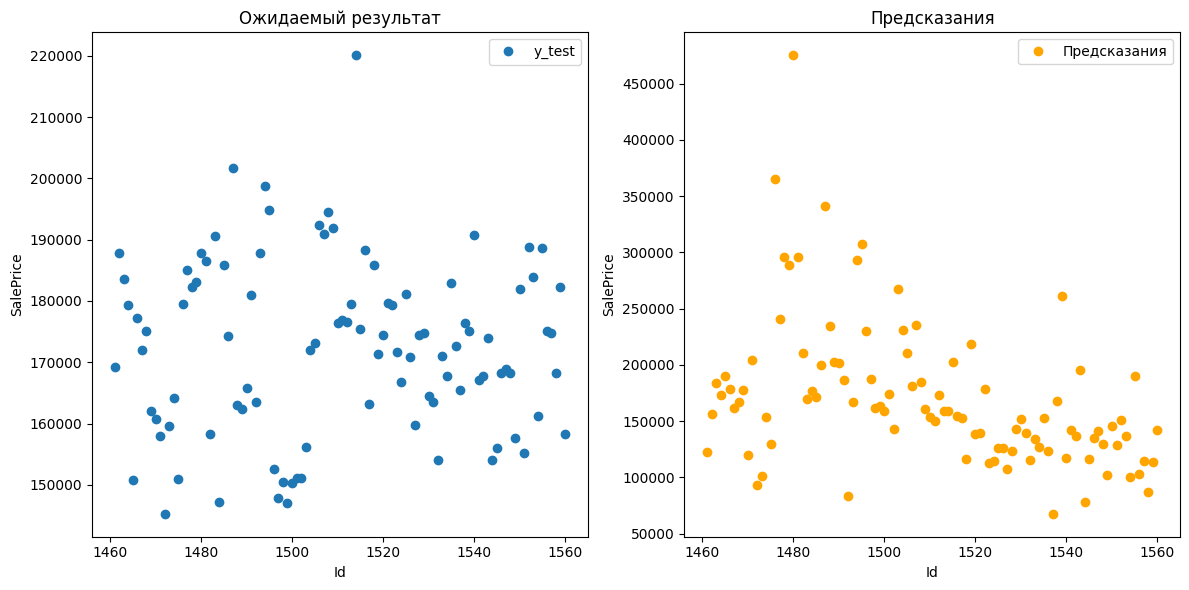

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(submission['Id'].head(100), submission['SalePrice'].head(100), marker='o', linestyle='', label='y_test')
axs[0].set_title('Ожидаемый результат')
axs[0].set_xlabel('Id')
axs[0].set_ylabel('SalePrice')
axs[0].legend()


axs[1].plot(predictions_df['Id'].head(100), predictions_df['SalePrice'].head(100), marker='o', linestyle='', color='orange', label='Предсказания')
axs[1].set_title('Предсказания')
axs[1].set_xlabel('Id')
axs[1].set_ylabel('SalePrice')
axs[1].legend()


plt.tight_layout()
plt.show()